In [1]:
%load_ext autoreload
%autoreload 2
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:96% !important; }</style>"))

import os
import torch
import matplotlib.pyplot as plt
from skimage.io import imread
import torch.nn as nn
import numpy as np
from skimage import img_as_ubyte
import imageio
import json
import cv2
import time
from PIL import Image
from pytorch3d.loss import (
    mesh_laplacian_smoothing, 
    mesh_normal_consistency,
)

import torch.nn.functional as F

from tqdm import tqdm_notebook
# Util function for loading meshes
from pytorch3d.io import load_objs_as_meshes, load_obj
import math
# Data structures and functions for rendering
from pytorch3d.structures import Meshes, Textures, join_meshes
from pytorch3d.renderer import (
    look_at_view_transform,
    OpenGLPerspectiveCameras, 
    SfMPerspectiveCameras,
    PointLights, 
    DirectionalLights,
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    TexturedSoftPhongShader,
    SoftSilhouetteShader,
    look_at_rotation,
    HardFlatShader
)

# add path for demo utils functions 
import sys
import os
import glob
sys.path.append(os.path.abspath(''))

from datetime import datetime
def now_str():
    now = datetime.now()
    month = str(now.month)
    day = str(now.day)
    hour = str(now.hour)
    minute = str(now.minute)
    sec = str(now.second)
    
    output = '[{:>02}/{:>02} {:>02}:{:>02}:{:>02}]'.format(month, day, hour, minute, sec)
    return output
def __output_log(path, strs):
    if not os.path.exists(path):
        with open(path, 'w+') as f:
            f.write(strs)
            f.close()
    else:
        with open(path, 'a+') as f:
            f.write(strs)
            f.close()
print(now_str())
print(torch.__version__)
print(torch.version.cuda)
def reproject(params, vertices, distort=False):
    R = params['R']
    T = params['T']
    fx = params['fx']
    fy = params['fy']
    cx = params['cx']
    cy = params['cy']

    E = np.array([
        [R[0,0], R[0,1], R[0,2], T[0]], 
        [R[1,0], R[1,1], R[1,2], T[1]], 
        [R[2,0], R[2,1], R[2,2], T[2]], 
        [0, 0, 0, 1]]).astype('double')
    
    if distort:
        k1 = params['k1']
        k2 = params['k2']
        k3 = params['k3']
        p1 = params['p1']
        p2 = params['p2']
        
    img_pts = []
    for i in range(len(vertices)):
        v = np.array(vertices[i])

        # extrinsics
        v4 = E.dot(np.array([v[0], v[1], v[2], 1]).astype('double'))
        xp = v4[0] / v4[2]
        yp = v4[1] / v4[2]

        if distort:
            # intrinsics
            r2 = xp**2 + yp**2
            ## radial
            radial_dist = 1 + k1*(r2) + k2*(r2*r2) + k3*(r2*r2*r2)

            ## tangential
            tan_x = p2 * (r2 + 2.0 * xp * xp) + 2.0 * p1 * xp * yp
            tan_y = p1 * (r2 + 2.0 * yp * yp) + 2.0 * p2 * xp * yp

            xp = xp * radial_dist + tan_x
            yp = yp * radial_dist + tan_y
            
        u = fx * xp + cx
        v = fy * yp + cy
        pr = 1
        nr = 0
        if (-4000*nr < u and u < pr*4000) and (-2160*nr < v and v < pr*2160):
            img_pts.append(np.array([u, v]))
    img_pts = np.array(img_pts)
    return img_pts

[04/18 21:30:23]
1.4.0
9.2


# Setup

In [2]:
print('torch.cuda.is_available():',torch.cuda.is_available())

device_gpu = torch.device("cuda:0")
torch.cuda.set_device(device_gpu)
device_cpu = torch.device('cpu')

print('torch.cuda.current_device():', torch.cuda.current_device())
torch.cuda.ipc_collect()
print('torch.cuda.get_device_name(0):',torch.cuda.get_device_name(0))

# print('GPU memory stats ---------------------')
# gpu_mem_stats = torch.cuda.memory_stats(device=device_gpu)
# for k, v in gpu_mem_stats.items():
#     print('  {}: {}'.format(k, v))

print(torch.cuda.memory_summary(device=device_gpu, abbreviated=False))
bytes_reserved = torch.cuda.memory_reserved()
print('torch.cuda.memory_reserved(): {:,.2f} Mb'.format(bytes_reserved * 0.000001))
# Returns the current GPU memory usage by 
# tensors in bytes for a given device
bytes_alloc = torch.cuda.memory_allocated()
print('torch.cuda.memory_allocated(): {:,.2f} Mb'.format(bytes_alloc * 0.000001))

# Returns the current GPU memory managed by the
# caching allocator in bytes for a given device
bytes_cached = torch.cuda.memory_cached()
print('torch.cuda.memory_cached(): {:,.2f} Mb'.format(bytes_cached * 0.000001))


# Releases all unoccupied cached memory currently held by
# the caching allocator so that those can be used in other
# GPU application and visible in nvidia-smi
print('----- torch.cuda.empty_cache() -----')

torch.cuda.empty_cache()
bytes_reserved = torch.cuda.memory_reserved()
print('torch.cuda.memory_reserved(): {:,.2f} Mb'.format(bytes_reserved * 0.000001))
bytes_alloc = torch.cuda.memory_allocated()
print('torch.cuda.memory_allocated(): {:,.2f} Mb'.format(bytes_alloc * 0.000001))
bytes_cached = torch.cuda.memory_cached()
print('torch.cuda.memory_cached(): {:,.2f} Mb'.format(bytes_cached * 0.000001))

torch.cuda.is_available(): True
torch.cuda.current_device(): 0
torch.cuda.get_device_name(0): GeForce RTX 2070 SUPER
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large pool |       0 B  |       0 B  |       0 B  |       0 B  |
|       from small pool |       0 B  |       0 B  |       0 B  |       0 B  |
|---------------------------------------------------------------------------|
| Active memory         |

# Model

torch.Size([6890, 3])
  - batch size: 1, num_batches: 16
  - cameras   : 16
  - renderers   : 16
torch.Size([1, 32, 32, 4])
torch.Size([1, 32, 32])
torch.Size([1, 32, 32, 4])
torch.Size([1, 32, 32])
torch.Size([1, 32, 32, 4])
torch.Size([1, 32, 32])
torch.Size([1, 32, 32, 4])
torch.Size([1, 32, 32])
torch.Size([1, 32, 32, 4])
torch.Size([1, 32, 32])
torch.Size([1, 32, 32, 4])
torch.Size([1, 32, 32])
torch.Size([1, 32, 32, 4])
torch.Size([1, 32, 32])
torch.Size([1, 32, 32, 4])
torch.Size([1, 32, 32])
torch.Size([1, 32, 32, 4])
torch.Size([1, 32, 32])
torch.Size([1, 32, 32, 4])
torch.Size([1, 32, 32])
torch.Size([1, 32, 32, 4])
torch.Size([1, 32, 32])
torch.Size([1, 32, 32, 4])
torch.Size([1, 32, 32])
torch.Size([1, 32, 32, 4])
torch.Size([1, 32, 32])
torch.Size([1, 32, 32, 4])
torch.Size([1, 32, 32])
torch.Size([1, 32, 32, 4])
torch.Size([1, 32, 32])
torch.Size([1, 32, 32, 4])
torch.Size([1, 32, 32])
images_rendered: (16, 32, 32, 4)
tensor(1004.3762, device='cuda:0', grad_fn=<AddBackwar

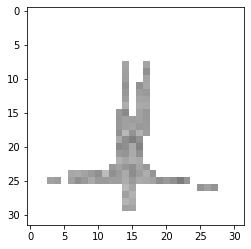

In [12]:
class Model(nn.Module):
    def __init__(self, device, **kwargs):
        """
        image_size: a scalar. Only square image is supported in PyTorch3d
        """
        stat_str = ''
        
        super().__init__()
        self.device = device
        self.cams = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P']

        self.image_size = kwargs.get('image_size', None)
        
        # set ref images: [0, 255] uint8
        image_refs = kwargs.get('image_refs', None)
        self.image_refs = torch.from_numpy(np.array(image_refs).astype(np.uint8)).to(self.device)
        
        # load texturemaps: [0.0, 1.0] float
        texturemap_shape = kwargs.get('texturemap_shape', None)
        texture_map_torch = torch.from_numpy(np.random.rand(1, texturemap_shape[0], texturemap_shape[1], texturemap_shape[2]).astype(np.float32)).to(self.device)
        self.texture_map = nn.Parameter(texture_map_torch, requires_grad=True)
        
        # batch_size
        self.batch_size = kwargs.get('batch_size', None)
        self.num_renders = len(self.image_refs)
        self.n_batch = int(self.num_renders / self.batch_size)
        
        # set mesh
        mesh_path = kwargs.get('mesh_path', None)
        self.meshes = self._load_meshes_list(self.device, [mesh_path], texture_map_torch)
        
        # vertex deformations
        self.vert_normals = self.meshes[0].verts_normals_packed()
        deform_verts = torch.from_numpy(np.zeros((self.vert_normals.shape), dtype=np.float32)).to(self.device)
        self.deform_verts = nn.Parameter(deform_verts, requires_grad=True)
        
        # init renderers
        cam_pararms = kwargs.get('cam_params', None)
        self.batch_renderers = self._init_renderer(cam_params=cam_pararms, batch_size=self.batch_size, n_batch=self.n_batch)
        
    def _load_meshes_list(self, device, mesh_paths, texture_map):
        meshes_list = []
        for path in mesh_paths:
            meshes_list.append(load_objs_as_meshes([path], universal_texturemap=texture_map.cpu(), device=device))
        return meshes_list
        
    def forward(self):
        loss = 0
        losses_dict = {'pixel': 0.0, 'mesh_normal': 0.0, 'mesh_laplacian': 0.0}
        stat_str = ''
        log = ''
        t0 = time.time()
        
        deformed_mesh = self.meshes[0].offset_verts(self.deform_verts)
        meshes = deformed_mesh.extend(self.batch_size)
        
        images_out = torch.zeros(self.image_refs.shape[0], self.image_refs.shape[1], self.image_refs.shape[2], 4)
        t1 = time.time()
        log += 'forward\n'
        log += ' - {:<10}: {:.3f}s\n'.format('data prep', t1 - t0)
        for batch_idx in range(self.n_batch):
            t2 = time.time()
            i0 = batch_idx*batch_size
            i1 = i0 + batch_size
            
            # [0.0, 1.0] float32 in gpu -> change to [0.0, 255.0] cpu. shape (batch_size, W, H, 4)
            image_cur, _ = self.batch_renderers[batch_idx](meshes_world=meshes, texture_maps=self.texture_map)
            # save for output
            images_out[i0:i1] = image_cur
            
            # [0, 255] float32 in cpu
            image_refs = self.image_refs[i0:i1]

            print(image_cur.shape)
            print(image_refs.shape)
            loss_i = (torch.mean((image_cur[...,0] - image_refs) ** 2) / 255.0)
            loss = loss + loss_i
            
            losses_dict['pixel'] += loss_i
            t3 = time.time()
            log += ' - [{}/{}] {:<10}: {:.3f}s\n'.format(batch_idx+1, self.n_batch, 'batch render', t3 - t2)
            log += '   ------------------------------------\n'
            log += '   ------------------------------------\n'
        loss_normal = 0.0
        loss_laplacian = 0.0
        
        losses_dict['mesh_normal'] += loss_normal
        losses_dict['mesh_laplacian'] += loss_laplacian
            
        loss = 1.0*loss + 0.5*loss_normal + 0.5*loss_laplacian
        return loss, images_out, self.texture_map, stat_str, losses_dict, log

    def get_gpu_stats(self, output_str=True):
        mb_reserved = torch.cuda.memory_reserved() * 0.000001
        mb_alloc = torch.cuda.memory_allocated() * 0.000001
        mb_cached = torch.cuda.memory_cached() * 0.000001
        if output_str:
            return 'alloc={:,.0f}MB | cached={:,.0f}MB | reserved={:,.0f}MB'.format(mb_alloc, mb_cached, mb_reserved)
        else:
            return mb_alloc, mb_cached, mb_reserved
        
    def _load_mesh(self, device, mesh_paths, texturemap_torch):
        # load mesh
        meshes = load_objs_as_meshes(mesh_paths, universal_texturemap=texturemap_torch, device=device)
        return meshes
    
    def save_parameters(self, out_path):
        deform_verts = self.deform_verts.detach().cpu().numpy()
        np.save(out_path, deform_verts)
        print('Parameters saved:', out_path)
        
    def load_parameters(self, in_path):
        self.deform_verts = nn.Parameter(torch.from_numpy(np.load(in_path)).to(self.device))
        print('Parameters loaded: {}'.format(self.deform_verts.shape))
        
    def export_obj(self, out_path):
        normal_deforms = self.deform_verts * self.vert_normals
        deformed_mesh = self.mesh.offset_verts(normal_deforms)

        verts = deformed_mesh.verts_packed()
        faces = deformed_mesh.faces_packed()
        vnormals = deformed_mesh.verts_normals_list()[0]
        fnormals = deformed_mesh.faces_normals_list()[0]

        assert(faces.shape[0] == fnormals.shape[0])
        assert(vnormals.shape[0] == verts.shape[0])

        with open(out_path, 'w+') as f:
            f.write('# OBJ file created by Hyojoon Park.\n')
            f.write('###########################\n')
            f.write('# Vertices:       {}\n'.format(verts.shape[0]))
            f.write('# Vertex normals: {}\n'.format(vnormals.shape[0]))
            f.write('# Faces:          {}\n'.format(faces.shape[0]))
            f.write('###########################\n')

            for i in range(verts.shape[0]):
                f.write('vn {:.4f} {:.4f} {:.4f}\n'.format(vnormals[i][0], vnormals[i][1], vnormals[i][2]))
                f.write('v {:.4f} {:.4f} {:.4f}\n'.format(verts[i][0], verts[i][1], verts[i][2]))

            for i in range(faces.shape[0]):
                f.write("f")
                face = faces[i, :]
                for fi in range(face.shape[0]):
                    f.write(' {0:.0f}//{0:.0f}'.format(face[fi] + 1, fnormals[fi] + 1))
#                     f.write(' {0:.0f}'.format(face[fi]))
                f.write("\n")

        print('Obj exported to:', out_path)
        
    def _init_renderer(self, cam_params, batch_size, n_batch):
        batch_renderers = []
        
        raster_settings = RasterizationSettings(
            image_size=self.image_size, 
            blur_radius=0.0, 
            faces_per_pixel=1, 
            bin_size = 0, # this setting controls whether naive or coarse-to-fine rasterization is used
            max_faces_per_bin = None  # this setting is for coarse rasterization
        )
        
        print('  - batch size: {}, num_batches: {}'.format(batch_size, n_batch))
        print('  - cameras   : {}'.format(cam_params['T'].shape[0]))
        locations = torch.from_numpy(np.array([0, 0, 3000])).to(self.device)
        a_diffuse = 0
        a_ambient = 0.5
        s = torch.from_numpy(np.zeros((1, 3)).astype(np.float32)).to(self.device)
        d = torch.from_numpy(np.ones((1, 3)).astype(np.float32)*a_diffuse).to(self.device)
        a = torch.from_numpy(np.ones((1, 3)).astype(np.float32)*a_ambient).to(self.device)
        light = PointLights(device=self.device, location=[[1000, 1000, 1000]], specular_color=s, ambient_color=a, diffuse_color=d)
        light.location = locations
        light.specular_color = s
        light.diffuse_color = d
        light.ambient_color = a
        
        for batch_idx in range(n_batch):
            i0 = batch_idx*batch_size
            i1 = i0 + batch_size
            R = cam_params['R'][i0:i1]
            T = cam_params['T'][i0:i1]
            focal_length = cam_params['fl'][i0:i1]
            principal_point = cam_params['pp'][i0:i1]
            cameras = SfMPerspectiveCameras(device=self.device, R=R, T=T, principal_point=principal_point, focal_length=focal_length)

            renderer = MeshRenderer(
                    rasterizer=MeshRasterizer(
                        cameras=cameras,
                        raster_settings=raster_settings
                    ),
                    shader=TexturedSoftPhongShader(
                        device=self.device, 
                        cameras=cameras,
                        lights=light
                    )
                )
            batch_renderers.append(renderer)
        print('  - renderers   : {}'.format(len(batch_renderers)))
        return batch_renderers
    
    def _merge_fg_bg(self, fg, bg):
        """
        fg: mesh rendering. [N, W, H, 4]: [0, 1.0] float
        bg: clean plate. [N, W, H]: [0, 255] uint8
        """
        out = torch.where(fg[...,0] < 1.0, 255.0*fg[...,0], bg)
        if len(out.shape) < 3:
            out = out.unsqueeze(0)
        return out
    
model = Model(device_gpu, img_dir=img_dir, cam_params=cams_torch, image_refs=img_refs, texturemap_shape=texturemap_shape, mesh_path=mesh_path, image_size=image_size, batch_size=batch_size)

lr = 1.0
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
optimizer.zero_grad()
loss, images_rendered, texture_map, stats_gpu, loss_dict, log = model()
loss.backward()
optimizer.step()
images_rendered = images_rendered.detach().squeeze().cpu().numpy()
print('images_rendered:',images_rendered.shape)
plt.imshow(images_rendered[0])
print(loss)
del model

# Load mesh, camera, images, and feed into the model

In [8]:
def load_cameras(cam_path, device, actual_img_shape):
    h = actual_img_shape[0]
    w = actual_img_shape[1]
    img_size = min(w, h)
    
    # load cameras
    cams = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P']

    with open(cam_path, 'r') as f:
        j = json.load(f)
        camera_params = j['cam_params']

    cameras = []
    cam_params = []
    cam_pos = []
    Rs, Ts, focal_lengths, principal_points = [], [], [], []
    for cam_idx, cam in enumerate(cams):
        cam_param = camera_params[str(cam_idx)]
        # for undistortion
        fx = cam_param['fx']
        fy = cam_param['fy']
        cx = cam_param['cx']
        cy = cam_param['cy']
        k1 = cam_param['k1']
        k2 = cam_param['k2']
        k3 = cam_param['k3']
        p1 = cam_param['p1']
        p2 = cam_param['p2']
        
        rvec = np.float32(cam_param['rvec'])
        T = np.float32(cam_param['tvec'])
        R, _ = cv2.Rodrigues(rvec)
        Rs.append(R.T)
        Ts.append(T)
        
        if cam_idx % 6 == 0:
            cam_pos.append(-R.T.dot(T))
        
        cx_corrected = cx*2/img_size - w/img_size
        cy_corrected = cy*2/img_size - h/img_size
        fx_corrected = fx*2/img_size
        fy_corrected = fy*2/img_size
        principal_point = np.array([cx_corrected, cy_corrected]).astype(np.float32)
        focal_length = np.array([fx_corrected, fy_corrected]).astype(np.float32)
        focal_lengths.append(focal_length)
        principal_points.append(principal_point)

        K = np.float32([[fx, 0, cx], [0, fy, cy], [0, 0, 1]])
        dist = np.float32([k1, k2, p1, p2, k3])
        cam_params.append({'K': K, 'dist': dist, 'R': R, 'T': T, 'fx': fx, 'fy': fy, 'cx': cx, 'cy': cy})
    
    R_torch = torch.from_numpy(np.array(Rs).astype(np.float32))
    T_torch = torch.from_numpy(np.array(Ts).astype(np.float32))
    focal_length = torch.from_numpy(np.array(focal_lengths).astype(np.float32))
    principal_point = torch.from_numpy(np.array(principal_points).astype(np.float32))
    out_for_torch = {'R': R_torch, 'T': T_torch, 'fl': focal_length, 'pp': principal_point}
    return cameras, cam_params, out_for_torch

def load_images(img_dir, cam_params):
    img_paths = sorted(glob.glob(img_dir + '/*.jpg'))
    image_refs0 = []
    image_refs_undistort = []
    for i, path in enumerate(img_paths):
        # img = imageio.imread(path)
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        img_undist = _undistort(img, cam_params[i])
        image_refs0.append(img)
        image_refs_undistort.append(img_undist)

    w = 2160 / 2
    image_refs_cropped = []
    for i in range(len(image_refs_undistort)):
        image = image_refs_undistort[i]
        cx = image.shape[1] / 2

        image = image_refs_undistort[i].astype(np.uint8)
        img = image[:, int(cx-w):int(cx+w)]
        img = cv2.resize(img, (image_size, image_size))
        img = cv2.flip(img, -1)
        image_refs_cropped.append(img)
    return image_refs0, image_refs_undistort, image_refs_cropped
                         
def _undistort(img, cam_param):
    # undistort a single image)
    h, w = img.shape[:2]
    # cv2.undistort(src, cameraMatrix, distCoeffs[, dst[, newCameraMatrix]]) → dst
    img = cv2.undistort(img, cam_param['K'], cam_param['dist'], None, None)
    return img
                         
def load_clean_plates(img_dir, cam_params):
    img_paths = sorted(glob.glob(img_dir + '/*.pgm'))
    images0 = []
    images_undistort = []
    for i, path in enumerate(img_paths):
        # img = imageio.imread(path)
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        img_undist = _undistort(img, cam_params[i])
        images0.append(img)
        images_undistort.append(img_undist)

    w = 2160 / 2
    clean_plates_cropped = []
    for i in range(len(images_undistort)):
        image = images_undistort[i]
        cx = image.shape[1] / 2

        image = images_undistort[i].astype(np.uint8)
        img = image[:, int(cx-w):int(cx+w)]
        img = cv2.resize(img, (image_size, image_size))
        img = cv2.flip(img, -1)
        # img = np.dstack([img, img, img])
        clean_plates_cropped.append(img)
    return images0, images_undistort, clean_plates_cropped 

# Load

In [9]:
cams = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P']
cam_path = './10b_data/input/cam_params.json'
mesh_path = './4_data/input/2020_03_28_SMPL_UV/SMPL_registration/SMPLFit_TPose.obj'
img_dir = './4_data/input/2020_03_28_SMPL_UV/SMPL_registration/TPose'
# clean_plate_dir = r'D:\200330_ToJanKeller\data\input\clean_plate'

# number of batch will be automatically computed
batch_size = 1

texturemap_shape = (32, 32, 1)
image_size = 32

# input image size
actual_img_shape = (2160, 4000)

In [10]:
# cam_path = './4_data/input/CameraCalibration/2020_03_22_NewSuitDesignCapture\FinalCamParams\cam_params.json'
# mesh_path = './4_data/input/2020_03_28_SMPL_UV/SMPL_registration/SMPLFit_TPose.obj'
# img_dir = './4_data/input/2020_03_28_SMPL_UV/SMPL_registration/TPose'
# texturemap_shape = (2160, 2160, 1)
# image_size = 2160

In [11]:
device = device_gpu
cameras, cam_params, cams_torch = load_cameras(cam_path, device, actual_img_shape=actual_img_shape)
img_refs_original, img_refs_undistorted, img_refs = load_images(img_dir, cam_params)
print(img_refs_undistorted[0].shape)


(2160, 4000)


#### check

In [ ]:
img = img_refs_original[0]
print('Image original =========')
print(img.shape, ',', np.max(img), ',', img.dtype)
print('{:,.2f} Mb'.format(img.nbytes * 0.000001))

print()
img = img_refs[0]
print('Image cropped =========')
print(img.shape, ',', np.max(img), ',', img.dtype)
print('{:,.2f} Mb'.format(img.size * img.itemsize * 0.000001))
print()
i = 5
fig, ax = plt.subplots(1, 3, figsize=(21, 7))
ax[0].imshow(img_refs_original[i], cmap='gray')
ax[0].set_title('original')
ax[1].imshow(img_refs_undistorted[i], cmap='gray')
ax[1].set_title('undistorted')
ax[2].imshow(img_refs[i], cmap='gray')
ax[2].set_title('undistorted & cropped')
ax[2].invert_yaxis()
plt.show()

del img

# Init model

In [ ]:
model = Model(device_gpu, img_dir=img_dir, cam_params=cams_torch, image_refs=img_refs, texturemap_shape=texturemap_shape, mesh_path=mesh_path, image_size=image_size, batch_size=batch_size)
texture_maps = model.texture_map
print('texture_map: {:,.2f}=={:,.2f} Mb'.format(texture_maps.element_size() * texture_maps.nelement() * 0.000001, texture_maps.detach().cpu().numpy().nbytes*0.000001))
texture_maps_np = texture_maps.detach().cpu().numpy()
print('  {} {:,.2f}Mb {} {}'.format(texture_maps.shape, texture_maps_np.nbytes*0.000001, texture_maps.dtype, np.max(texture_maps_np)))
img = model.image_refs[0]
print('ref image: {}, {:,.2f} Mb'.format(img.shape, img.element_size() * img.nelement() * 0.000001))



lr = 1.0
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
optimizer.zero_grad()
loss, images_rendered, texture_map, stats_gpu, loss_dict, log = model()
loss.backward()
optimizer.step()
images_rendered = images_rendered.detach().squeeze().cpu().numpy()
print('images_rendered:',images_rendered.shape)
plt.imshow(images_rendered[0])
print(loss)
del model

### pytorch3d mesh rendering 

In [ ]:
from utils import image_grid
bytes_alloc = torch.cuda.memory_allocated()
print('torch.cuda.memory_allocated(): {:,.2f} Mb'.format(bytes_alloc * 0.000001))
bytes_cached = torch.cuda.memory_cached()
print('torch.cuda.memory_cached(): {:,.2f} Mb'.format(bytes_cached * 0.000001))

t0 = time.time()
loss, images_rendered, texture_map, stats_gpu, loss_dict, log = model()
t1 = time.time()
# model.save_parameters('./7_data/output/deform_verts.npy')
# model.export_obj('./7_data/output/obj.obj')
t2 = time.time()
print('forward:{:.2f}s, save:{:.2f}'.format(t1-t0, t2-t1))

bytes_alloc = torch.cuda.memory_allocated()
print('torch.cuda.memory_allocated(): {:,.2f} Mb'.format(bytes_alloc * 0.000001))
bytes_cached = torch.cuda.memory_cached()
print('torch.cuda.memory_cached(): {:,.2f} Mb'.format(bytes_cached * 0.000001))

print(log)
# mesh from pytorch3d
i = 0
img_mesh = images_rendered.squeeze().detach().cpu().numpy()
print(img_mesh.shape)
for batch_idx in range(model.n_batch):
    fig, ax = plt.subplots(1, model.batch_size, figsize=(model.batch_size*5, 5))
    if model.batch_size > 1:
        ax = ax.ravel()
        for n in range(model.batch_size):
            img_mesh2 = img_mesh[i]
            img_mesh2 = cv2.flip(img_mesh2, -1)
            ax[n].set_title('batch[{}][{}] | i={}'.format(batch_idx, i, batch_idx*batch_size + i + 1))
            ax[n].imshow(img_mesh2, cmap='gray')
            i += 1
    else:
        img_mesh2 = img_mesh[i]
        img_mesh2 = cv2.flip(img_mesh2, -1)
        ax.set_title('batch[{}][{}] | i={}'.format(batch_idx, i, batch_idx*batch_size + i + 1))
        ax.imshow(img_mesh2, cmap='gray')
        i += 1
    break
plt.show()
# print(stats_gpu)

##### add clean plate background

In [ ]:
def merge_fg_bg(fg, bg):
    """
    fg: mesh rendering. [W, H, 4]: [0, 1.0] float
    bg: clean plate. [W, H]: [0, 255] uint8
    """
    max_pixel = np.max(fg)
    out = np.where(fg[...,0] < max_pixel, 255*fg[...,0], bg)
    return out
    
img_idx = 0
cp = clean_plates[img_idx]
img = img_mesh[img_idx]
img2 = merge_fg_bg(img, cp)
plt.imshow(img2, cmap='gray', vmin=0, vmax=255)
plt.gca().invert_yaxis()
plt.show()
plt.imshow(img, cmap='gray', vmin=0, vmax=255)
plt.gca().invert_yaxis()
plt.show()

### reprojections of obj

In [ ]:
mesh_vertices = model.meshes.verts_packed().cpu()
mesh_points = []

t0 = time.time()
for cam_idx in range(16):
    params = cam_params[cam_idx]
    pts = reproject(params, mesh_vertices, distort=False)
    mesh_points.append(pts)
t1 = time.time()
print('{:.2f}s'.format(t1-t0))
print(pts.shape)
print(len(mesh_points))
del mesh_vertices

In [ ]:
%matplotlib inline
for i in range(16):
    plt.figure(figsize=(10, 10))
    # bg
    img_bg = img_refs[i]
    img_bg = cv2.flip(img_bg, -1)
    plt.imshow(img_bg, cmap='gray')
    
    # mesh from pytorch3d
    img_mesh = images_rendered[i].squeeze().detach().cpu().numpy()[..., :3]
    img_mesh2 = img_mesh
    img_mesh2 = cv2.flip(img_mesh2, -1)
    plt.imshow(img_mesh2, alpha=0.5, cmap='gray')
    
    pts = mesh_points[i]
    pts_small_x = (pts[:, 0] - (4000-2160)*0.5) * image_size/2160
    pts_small_y = pts[:, 1] * image_size/2160
    pts_small = np.stack([pts_small_x, pts_small_y]).T
    pts_center = np.mean(pts_small, axis=0)
    plt.scatter(pts_small[:, 0], pts_small[:, 1], c='b', s=0.01)
    plt.title('Camera {}'.format(i))
    
    # plot centers
    plt.scatter(pts_center[0], pts_center[1], c='r')
    
    if i == 0:
        print('reference image:', np.max(img_bg), img_bg.dtype, img_bg.shape)
        print('rendered pytorch image :', np.max(img_mesh), img_mesh.dtype, img_mesh.shape, ', {:,.2f} Mb'.format(img_mesh.nbytes * 0.000001), np.max(img_mesh))
        print('rendered pytorch image2:', np.max(img_mesh2), img_mesh2.dtype, img_mesh2.shape, ', {:,.2f} Mb'.format(img_mesh2.nbytes * 0.000001), np.max(img_mesh2))
    plt.show()

# Train

In [12]:
def visualize_LR(e, lr, losses, images, imgR, out_path):
    cams = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P']
    img_meshes = []
    for i in range(len(images)):
        img = images[i].detach().squeeze(0).cpu().numpy()
        img_mesh = np.clip(cv2.flip(img, -1), a_min=0.0, a_max=1.0)
        img_meshes.append(img_mesh)
        
    fig = plt.figure(figsize=(18, 3), tight_layout=True)
    
    gs = fig.add_gridspec(2, 12)
    for r in range(2):
        for c in range(8):
            i = r*8 + c
            ax = fig.add_subplot(gs[r, c])
            ax.set_title('{}'.format(cams[i]))
            ax.imshow(img_meshes[i], cmap='gray')
            ax.set_xticks([])
            ax.set_yticks([])
    ax = fig.add_subplot(gs[:, 8:10])
    ax.plot(losses)
    ax.set_title('loss={:.8f}'.format(losses[-1]))
    
    ax = fig.add_subplot(gs[:, 10:12])
    imgR2 = imgR.squeeze().detach().cpu().numpy()
    imgR2 = np.clip(imgR2, a_min=0.0, a_max=1.0)
    ax.imshow(imgR2, cmap='gray', vmin=0, vmax=1.0)
    ax.set_title('Learned Texturemap')
    
    plt.suptitle('Epoch: {:<10}  lr: {:<.4f}'.format(e, lr))
    plt.savefig(out_path, dpi=150)
    plt.close('all')
    
    saved_img = imageio.imread(save_path)
    return saved_img

def visualize2(e, lr, losses, losses_dict, image1, image2, image3, out_path):
    fig, ax = plt.subplots(1, 4, figsize=(24, 6), tight_layout=True)
    ax = ax.ravel()
    
    ax[0].plot(losses)
    ax[0].set_title('Epoch={}, lr={:.4f}, loss={:.4f}, pixel_loss={:.4f}'.format(e, lr, losses[-1], losses_dict['pixel']))
    
    ax[1].imshow(image1, cmap='gray', vmin=0, vmax=255)
    ax[1].invert_yaxis()
    ax[1].set_title('Current image')
    
    ax[2].imshow(image2, cmap='gray', vmin=0, vmax=255)
    ax[2].invert_yaxis()
    ax[2].set_title('Target image')

    ax[3].imshow(image3, cmap='gray', vmin=0, vmax=1.0)
    ax[3].set_title('Learned texturemap')

    
    plt.savefig(out_path, dpi=300)
    plt.close('all')
    
    saved_img = imageio.imread(save_path)
    return saved_img
    
def get_gpu_stats(output_str=True):
    mb_reserved = torch.cuda.memory_reserved() * 0.000001
    mb_alloc = torch.cuda.memory_allocated() * 0.000001
    mb_cached = torch.cuda.memory_cached() * 0.000001
    if output_str:
        return 'alloc={:,.0f}MB | cached={:,.0f}MB | reserved={:,.0f}MB'.format(mb_alloc, mb_cached, mb_reserved)
    else:
        return mb_alloc, mb_cached, mb_reserved

In [ ]:
save_path = r'./7_data/output/plot.png'
# saved_img = visualize_LR(0, 0, [100, 10, 1], images_rendered, texture_map, save_path)
i = 0
image1 = images_rendered.squeeze().detach().cpu().numpy()[i]
image2 = img_refs[i]
image3 = texture_map.detach().squeeze().cpu().numpy()
saved_img = visualize2(1, 2, [3, 4, 5], image1, image2, image3, save_path)
plt.figure(figsize=(24, 6))
plt.imshow(saved_img)

# Init mesh & texturemap

In [16]:
print('----- torch.cuda.empty_cache() -----')
torch.cuda.empty_cache()
bytes_alloc = torch.cuda.memory_allocated()
print('torch.cuda.memory_allocated(): {:,.2f} Mb'.format(bytes_alloc * 0.000001))
bytes_cached = torch.cuda.memory_cached()
print('torch.cuda.memory_cached(): {:,.2f} Mb'.format(bytes_cached * 0.000001))

model = Model(device_gpu, img_dir=img_dir, cam_params=cams_torch, image_refs=img_refs, texturemap_shape=texturemap_shape, mesh_path=mesh_path, image_size=image_size, batch_size=batch_size)


----- torch.cuda.empty_cache() -----
torch.cuda.memory_allocated(): 1.99 Mb
torch.cuda.memory_cached(): 6.29 Mb
  - batch size: 1, num_batches: 16
  - cameras   : 16
  - renderers   : 16


In [ ]:
loss, images, texels, stat_gpu, losses_dict, _ = model()
i = 0
save_path = r'./7_data/output/plot.png'
image1 = images.squeeze().detach().cpu().numpy()[i]
image2 = img_refs[i]
image3 = texels.detach().squeeze().cpu().numpy()
saved_img = visualize2(1, 2, [3, 4, 5], losses_dict, image1, image2, image3, save_path)
plt.figure(figsize=(40, 10))
plt.imshow(saved_img)

Log output: ./10b_data/output/log_20200415_02h10m.txt


<ipython-input-17-67bd7d3022fe>:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  loop = tqdm_notebook(range(1000000000))


torch.Size([1, 32, 32, 4])
torch.Size([1, 32, 32])
torch.Size([1, 32, 32, 4])
torch.Size([1, 32, 32])
torch.Size([1, 32, 32, 4])
torch.Size([1, 32, 32])
torch.Size([1, 32, 32, 4])
torch.Size([1, 32, 32])
torch.Size([1, 32, 32, 4])
torch.Size([1, 32, 32])
torch.Size([1, 32, 32, 4])
torch.Size([1, 32, 32])
torch.Size([1, 32, 32, 4])
torch.Size([1, 32, 32])
torch.Size([1, 32, 32, 4])
torch.Size([1, 32, 32])
torch.Size([1, 32, 32, 4])
torch.Size([1, 32, 32])
torch.Size([1, 32, 32, 4])
torch.Size([1, 32, 32])
torch.Size([1, 32, 32, 4])
torch.Size([1, 32, 32])
torch.Size([1, 32, 32, 4])
torch.Size([1, 32, 32])
torch.Size([1, 32, 32, 4])
torch.Size([1, 32, 32])
torch.Size([1, 32, 32, 4])
torch.Size([1, 32, 32])
torch.Size([1, 32, 32, 4])
torch.Size([1, 32, 32])
torch.Size([1, 32, 32, 4])
torch.Size([1, 32, 32])


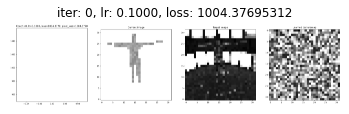

torch.Size([1, 32, 32, 4])
torch.Size([1, 32, 32])
torch.Size([1, 32, 32, 4])
torch.Size([1, 32, 32])
torch.Size([1, 32, 32, 4])
torch.Size([1, 32, 32])
torch.Size([1, 32, 32, 4])
torch.Size([1, 32, 32])
torch.Size([1, 32, 32, 4])
torch.Size([1, 32, 32])
torch.Size([1, 32, 32, 4])
torch.Size([1, 32, 32])
torch.Size([1, 32, 32, 4])
torch.Size([1, 32, 32])
torch.Size([1, 32, 32, 4])
torch.Size([1, 32, 32])
torch.Size([1, 32, 32, 4])
torch.Size([1, 32, 32])
torch.Size([1, 32, 32, 4])
torch.Size([1, 32, 32])
torch.Size([1, 32, 32, 4])
torch.Size([1, 32, 32])
torch.Size([1, 32, 32, 4])
torch.Size([1, 32, 32])
torch.Size([1, 32, 32, 4])
torch.Size([1, 32, 32])
torch.Size([1, 32, 32, 4])
torch.Size([1, 32, 32])
torch.Size([1, 32, 32, 4])
torch.Size([1, 32, 32])
torch.Size([1, 32, 32, 4])
torch.Size([1, 32, 32])
torch.Size([1, 32, 32, 4])
torch.Size([1, 32, 32])
torch.Size([1, 32, 32, 4])
torch.Size([1, 32, 32])
torch.Size([1, 32, 32, 4])
torch.Size([1, 32, 32])
torch.Size([1, 32, 32, 4])
torc

KeyboardInterrupt: 

In [17]:
out_dir = './10b_data/output'
save_path = out_dir + '/plot.png'

# filename_output = './4_data/output/4b/out.gif'
# writer = imageio.get_writer(filename_output, mode='I', duration=0.3)
now = datetime.now()
hour = str(now.hour)
minute = str(now.minute)
date_str = '{}{:>02}{:>02}_{:>02}h{:>02}m'.format(now.year, now.month, now.day, hour, minute)
log_path = out_dir + '/log_{}.txt'.format(date_str)
__output_log(log_path, '========== {} Start ==========================\n'.format(date_str))
print('Log output: {}'.format(log_path))

lr = 0.1
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

loop = tqdm_notebook(range(1000000000))

losses = []
loss_belows, loss_aboves = 0, 0
losses_below, losses_above = [], []
latest_states = {}
with torch.autograd.profiler.profile() as prof:
    for e in loop:
        stat_str = '1 {:<21}: {}\n'.format('epoch starts'.format(e), get_gpu_stats())
        output_texels = (e % 10 == 0)
        
        if e > 0 and e % 200 == 0:
            optimizer.param_groups[0]['lr'] *= 0.5
            
        t0 = time.time()
        optimizer.zero_grad()
        stat_str += '2 {:<21}: {}\n'.format('optimizer.zero_grad()', get_gpu_stats())
        t1 = time.time()
        
        if output_texels:
            loss, images, texels, stat_gpu, loss_dict, _ = model()
            latest_states['loss'] = loss
            latest_states['images'] = images.clone()
            latest_states['texels'] = texels.clone()
            latest_states['loss_dict'] = loss_dict
        else:
            loss, _, _, stat_gpu, loss_dict, _ = model()
            latest_states['loss'] = loss
            latest_states['loss_dict'] = loss_dict
            
        if e > 0 and e % 50 == 0:
            model.save_parameters('./7_data/output/deform_verts.npy')
            model.export_obj('./7_data/output/obj.obj')
            
        stat_str += '3 {:<21}: {}\n'.format('forward', get_gpu_stats())
        stat_str += stat_gpu
        t2 = time.time()
        loss.backward()
        stat_str += '4 {:<21}: {}\n'.format('backward', get_gpu_stats())
        t3 = time.time()
        
        optimizer.step()
        stat_str += '5 {:<21}: {}\n'.format('optimizer.step()', get_gpu_stats())
        t4 = time.time()
        losses.append(loss)
        losses_below.append(loss_belows)
        losses_above.append(loss_aboves)

        loop.set_description('[{}/{}] loss={:.6f}'.format(e, len(loop), loss.data))
        lr = optimizer.param_groups[0]['lr']
        
        if output_texels:
            # Save outputs to create a GIF. 
            t10 = time.time()
            
            save_idx = 0
            image1 = images.squeeze().detach().cpu().numpy()[save_idx]
            image2 = img_refs[save_idx]
            image3 = texels.detach().squeeze().cpu().numpy()
            saved_img = visualize2(e, lr, losses, loss_dict, image1, image2, image3, save_path)
            # image_out = visualize_LR(e, lr, losses, images, texels, save_path)
            plt.figure()
            plt.imshow(saved_img)
            plt.title("iter: %d, lr: %0.4f, loss: %0.8f" % (e, lr, loss.data))
            plt.grid("off")
            plt.axis("off")
            plt.show()
            plt.close('all')
            
            texels_np = model.texture_map.detach().cpu().numpy()
            np.save(out_dir + '/texturemap.npy', texels_np)
            del texels_np
            
            texturemap_out = (255.0*np.clip(model.texture_map.detach().squeeze().cpu().numpy(), a_min=0, a_max=1.0)).astype(np.uint8)
            im = Image.fromarray(texturemap_out)
            im.save(out_dir + '/texturemap_learned.png', dpi=(600, 600))
            t11 = time.time()

#             image_out = image_out / 255.0
#             image_out = np.clip(image_out, 0, 1)
#             image_out = img_as_ubyte(image_out)
#             writer.append_data(image_out)
            t12 = time.time()
            
            __output_log(log_path, '{:03} | plot({:.2f}s) | gif({:.2f}s)\n'.format(e+1, t11-t10, t12-t11))
#             stat_str += '  {:<21}: {}\n'.format('plotting', get_gpu_stats())
        # execution time
        t01 = t1-t0
        t12 = t2-t1
        t23 = t3-t2
        t34 = t4-t3
        t5 = time.time()
        
        mb_alloc = torch.cuda.memory_allocated() * 0.000001
        mb_cached = torch.cuda.memory_cached() * 0.000001
        now = datetime.now()
        hour = str(now.hour)
        minute = str(now.minute)
        second = str(now.second)
        now_str = '{:>02}:{:>02}:{:>02}'.format(hour, minute, second)
        __output_log(log_path, '{} | {:03} | {:.2f}s | lr={:.8f} | loss={:.6f} | pixel_l={:.4f} | normal_l={:.4f} | lap_l={:.4f} | zero_grad({:.2f}s) | forward({:.2f}s) | backward({:.2f}s) | step({:.2f}s) | GPU_allocated({:,.2f}Mb) | GPU_cached({:,.2f}Mb)\n'.format(now_str, e+1, t5-t0, lr, loss, loss_dict['pixel'], loss_dict['mesh_normal'], loss_dict['mesh_laplacian'], t01, t12, t23, t34, mb_alloc, mb_cached))
        
        # clean up
        if output_texels:
            del loss, images, texels
        else:
            del loss
        stat_str += '7 {:<21}: {}\n'.format('clean up', get_gpu_stats())

        torch.cuda.empty_cache()
        stat_str += '8 {:<21}: {}\n'.format('empty_cache()', get_gpu_stats())
        __output_log(log_path, '{}'.format(stat_str))
        if e > 620:
            break
            
torch.cuda.empty_cache()
# loss, images, texels, stat_str = model()
loss, images, texels = latest_states['loss'], latest_states['images'], latest_states['texels']
print(stat_str)

save_dir = out_dir
for i in range(len(images)):
    print(' ', i+1, end='')
    fig, ax = plt.subplots(1, 2, figsize=(24, 12), tight_layout=True)
    img = images[i].detach().cpu().numpy()
    ax[0].imshow(img, cmap='gray', vmin=0, vmax=255)
    ax[0].invert_yaxis()
    ax[1].imshow(img_refs[i], cmap='gray')
    ax[1].invert_yaxis()
    plt.savefig(save_dir + '/compare_cam{}.png'.format(i+1), dpi=300)
print(save_dir)

In [ ]:
# plt.figure()
# # plt.plot(losses, 'k')
# plt.plot(losses_above, 'r')
# plt.plot(losses_below, 'b')

In [ ]:
torch.cuda.empty_cache()
# loss, images, texels, stat_str = model()
loss, images, texels = latest_states['loss'], latest_states['images'], latest_states['texels']
print(stat_str)

In [ ]:
texture_maps = texels.detach().squeeze().cpu()
td = texels.detach().cpu()
print(td.shape)
print(torch.min(td),',', torch.max(td))

td_a = torch.clamp(-1.0*texture_maps, min=0.0)
print('n_above:', torch.sum(td_a > 0.0))
td_b = torch.clamp(texture_maps, min=1.0) - torch.ones(texture_maps.shape)
print('n_below:', torch.sum(td_b > 1.0))
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(td_a, vmin=0, vmax=1.0)
ax[0].set_title('Pixels > 1.0')
ax[1].imshow(td_b, vmin=0, vmax=1.0)
ax[1].set_title('Pixels < 0.0')
plt.figure()
plt.imshow(td.clone().squeeze().numpy(), cmap='gray', vmin=0, vmax=1.0)

### save rendered images

In [ ]:
save_dir = out_dir
for i in range(len(images)):
    print(' ', i+1, end='')
    fig, ax = plt.subplots(1, 2, figsize=(24, 12), tight_layout=True)
    img = images[i].detach().cpu().numpy()
    ax[0].imshow(img, cmap='gray', vmin=0, vmax=255)
    ax[0].invert_yaxis()
    ax[1].imshow(img_refs[i], cmap='gray')
    ax[1].invert_yaxis()
    plt.savefig(save_dir + '/compare_cam{}.png'.format(i+1), dpi=300)
print(save_dir)

### visualize

In [ ]:
%matplotlib inline
fig, ax = plt.subplots(16, 1, figsize=(15, 140))
ax = ax.ravel()
for i in range(len(ax)):
    img_mesh = images_rendered[i]
    img_mesh = cv2.flip(img_mesh, -1)
    img_bg = image_refs[i]
    img_bg = cv2.flip(img_bg, -1)
    ax[i].imshow(img_bg)

    img_mesh_large = np.zeros(img_bg.shape)
    img_mesh_padded = cv2.copyMakeBorder(img_mesh, 0, 0, int((4000-2160)/2), int((4000-2160)/2), 0, None, [0, 0, 0])
    ax[i].imshow(img_mesh, alpha=0.5)
    
    pts = mesh_points[i]
    pts_small_x = (pts[:, 0] - (4000-2160)*0.5) * rendered_image_size/2160
    pts_small_y = pts[:, 1] * rendered_image_size/2160
    pts_small = np.stack([pts_small_x, pts_small_y]).T
    pts_center = np.mean(pts_small, axis=0)
#     ax[i].scatter(pts[:, 0], pts[:, 1], c='r', s=0.1)
#     ax[i].scatter(pts_small[:, 0], pts_small[:, 1], c='r', s=0.01)
    ax[i].set_title('Camera {}'.format(cams[i]))
    
    # plot centers
    ax[i].scatter(pts_center[0], pts_center[1], c='r')


In [ ]:
writer.close()

In [ ]:
class Model(nn.Module):
    def __init__(self, meshes, image_refs, renderers, texture_maps):
        super().__init__()
        self.meshes = meshes
        self.device = meshes.device
        self.renderers = renderers
        self.register_buffer('image_refs', image_refs)

        self.texture_maps = nn.Parameter(texture_maps.to(meshes.device), requires_grad=True)
        
    def forward(self):
        loss = 0
        images = []
        for i in range(len(self.renderers)):
            image = self.renderers[i](meshes_world=self.meshes, texture_maps=self.texture_maps)
            loss_i = torch.mean((image.squeeze()[..., :3] - self.image_refs[i]) ** 2)
            images.append(image)
            loss = loss + loss_i
        loss /= len(self.renderers)

        return loss, images, self.texture_maps.data

# After traning

In [ ]:
plt.figure()
plt.plot(losses)
plt.show()

In [ ]:
plt.figure()
plt.imshow(model.texture_maps.detach().cpu().numpy()[0, :, :, :])
plt.savefig('./4_data/output/4b/texturemap_learned.png', dpi=600)
plt.show()

In [ ]:
x = torch.randn((1, 1), requires_grad=True)
with torch.autograd.profiler.profile() as prof:
    print(prof)
    for _ in range(100):  # any normal python code, really!
        y = x ** 2
        y.backward()
# NOTE: some columns were removed for brevity
print(prof.key_averages().table(sort_by="self_cpu_time_total"))

In [ ]:
torch.cuda.memory_stats(device=device_gpu)

In [ ]:
print(torch.cuda.memory_summary(device=device_gpu, abbreviated=True))

In [ ]:
mem_stats = torch.cuda.memory_stats(device=device_gpu)
for k, v in mem_stats.items():
    print('{}: {}'.format(k, v))

In [ ]:
print(torch.cuda.max_memory_allocated(device=device_gpu))